In [27]:
import pickle
import os
import numpy as np
import tensorflow as tf
import pandas as pd

In [28]:
X,y = pickle.load(open('../data/xyhighpass.p','rb'))

In [29]:
X = np.nan_to_num(X[:,:,:])
y = np.array(y)
groups = y

In [30]:
def separate_known_unknown_users(X,y,groups,split_ratio = .2):
    from sklearn.model_selection import LeavePGroupsOut
    n_users = len(np.unique(groups))
    lpgo = LeavePGroupsOut(n_groups=int(n_users*split_ratio))
    for train_index, test_index in lpgo.split(X, y, groups=groups):
        X_keep, X_out = X[train_index], X[test_index]
        y_keep, y_out = y[train_index], y[test_index]
        groups_keep, groups_out = groups[train_index], groups[test_index]
        break
    return X_keep,X_out,y_keep,y_out,groups_keep,groups_out
X_keep,X_test_out,y_keep,y_test_out,groups_keep,groups_test_out = separate_known_unknown_users(X,y,groups,split_ratio=.2)

X_in,X_val_out,y_in,y_val_out,groups_in,groups_val_out = separate_known_unknown_users(X_keep,y_keep,groups_keep,split_ratio=.1)

from sklearn.model_selection import train_test_split
X_train, X_test_in, y_train, y_test_in,groups_train,groups_test_in = train_test_split(X_in, y_in,groups_in, test_size=0.2, random_state=42,stratify=groups_in)

X_train_in, X_val_in, y_train_in, y_val_in,groups_train_in,groups_val_in = train_test_split(X_train, y_train,groups_train, test_size=0.1, random_state=42,stratify=groups_train)

In [31]:
from keras.layers import *
from keras.models import *
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,BatchNormalization,Dropout,Input,MaxPooling1D,Flatten,Dense,Input
from keras.models import Model, Sequential
y_train_in = y_train_in-np.min(y_train_in)
y_val_in = y_val_in-np.min(y_val_in)
y_test_in = y_test_in-np.min(y_test_in)
from keras.models import load_model

In [32]:
train_data = pd.DataFrame({'x':list(X_train_in),'y':list(y_train_in),'group':groups_train_in})
val_data_in = pd.DataFrame({'x':list(X_val_in),'y':list(y_val_in),'group':groups_val_in})
val_data_out = pd.DataFrame({'x':list(X_val_out),'y':list(y_val_out),'group':groups_val_out})
test_data_in = pd.DataFrame({'x':list(X_test_in),'y':list(y_test_in),'group':groups_test_in})
test_data_out = pd.DataFrame({'x':list(X_test_out),'y':list(y_test_out),'group':groups_test_out})

In [33]:
ppg_only_filepath = '../model_files/base_cnn_20_seconds_ppg_only.hdf5'
acl_only_filepath = '../model_files/base_cnn_20_seconds_acl_only.hdf5'
gyro_only_filepath = '../model_files/base_cnn_20_seconds_gyro_only.hdf5'
ppg_model = load_model(ppg_only_filepath)
acl_model = load_model(acl_only_filepath)
gyro_model = load_model(gyro_only_filepath)

Base Test Accuracy

In [45]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,classification_report

y_test_pred_ppg = ppg_model.predict(X_test_in[:,:,:3])

y_test_pred_ppg = np.argmax(y_test_pred_ppg,axis=1)

y_test_pred_acl = acl_model.predict(X_test_in[:,:,3:6])

y_test_pred_acl = np.argmax(y_test_pred_acl,axis=1)

y_test_pred_gyro = gyro_model.predict(X_test_in[:,:,6:])

y_test_pred_gyro = np.argmax(y_test_pred_gyro,axis=1)


# for i in range(100):
#     print(np.argmax(y_test_pred_ppg[i]),y_test_in[i])
print('ppg base accuracy', accuracy_score(y_test_in,y_test_pred_ppg))
print('acl base accuracy', accuracy_score(y_test_in,y_test_pred_acl))
print('gyro base accuracy', accuracy_score(y_test_in,y_test_pred_gyro))

ppg base accuracy 0.14597574421168688
acl base accuracy 0.16957001102535832
gyro base accuracy 0.2611749881871161


Ensemble Accuracy

In [71]:
y_test_pred_ppg = ppg_model.predict(X_test_in[:,:,:3])
y_test_pred_acl = acl_model.predict(X_test_in[:,:,3:6])
y_test_pred_gyro = gyro_model.predict(X_test_in[:,:,6:])

In [73]:
from scipy.stats import mode
from joblib import Parallel,delayed
test_lengths = np.arange(60,30*60,60)
base_length = 20
groups = np.unique(test_data_in['y'])
n_iter = 100
test_data_in['index'] = test_data_in.index

def get_accuracy_ensemble(t,n_iter,y_test_pred_ppg,test_data_in):
    m = int(t/base_length)
    y_pred_maxmean = []
    y_pred_majority = []
    y_true = []
    for g in groups:
        for _ in range(n_iter):
            index_col = test_data_in[test_data_in.y==g]['index'].sample(m)
            y_true.append(g)
            y_test_pred_window = y_test_pred_ppg[index_col]
            g_pred_maxmean = np.argmax(np.mean(y_test_pred_window,axis=0))
            y_pred_maxmean.append(g_pred_maxmean)
            g_pred_majority = mode(np.argmax(y_test_pred_window,axis=1))[0]
            y_pred_majority.append(g_pred_majority)
    return np.array([t/60,accuracy_score(y_true,y_pred_maxmean),accuracy_score(y_true,y_pred_majority)])

ppg_output = Parallel(n_jobs=20,verbose=2)(delayed(get_accuracy_ensemble)(t,n_iter,y_test_pred_ppg,test_data_in) for t in test_lengths)
ppg_output = np.array(ppg_output)
acl_output = Parallel(n_jobs=20,verbose=2)(delayed(get_accuracy_ensemble)(t,n_iter,y_test_pred_acl,test_data_in) for t in test_lengths)
acl_output = np.array(acl_output)
gyro_output = Parallel(n_jobs=20,verbose=2)(delayed(get_accuracy_ensemble)(t,n_iter,y_test_pred_gyro,test_data_in) for t in test_lengths)
gyro_output = np.array(gyro_output)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  29 | elapsed:   45.1s remaining:  3.6min
[Parallel(n_jobs=20)]: Done  20 out of  29 | elapsed:  1.7min remaining:   46.2s
[Parallel(n_jobs=20)]: Done  29 out of  29 | elapsed:  2.3min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  29 | elapsed:   43.4s remaining:  3.5min
[Parallel(n_jobs=20)]: Done  20 out of  29 | elapsed:  1.7min remaining:   46.9s
[Parallel(n_jobs=20)]: Done  29 out of  29 | elapsed:  2.3min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  29 | elapsed:   42.9s remaining:  3.4min
[Parallel(n_jobs=20)]: Done  20 out of  29 | elapsed:  1.7min remaining:   46.7s
[Parallel(n_jobs=20)]: Done  29 out of  29 | elapsed:  2.3min finished


<IPython.core.display.Javascript object>


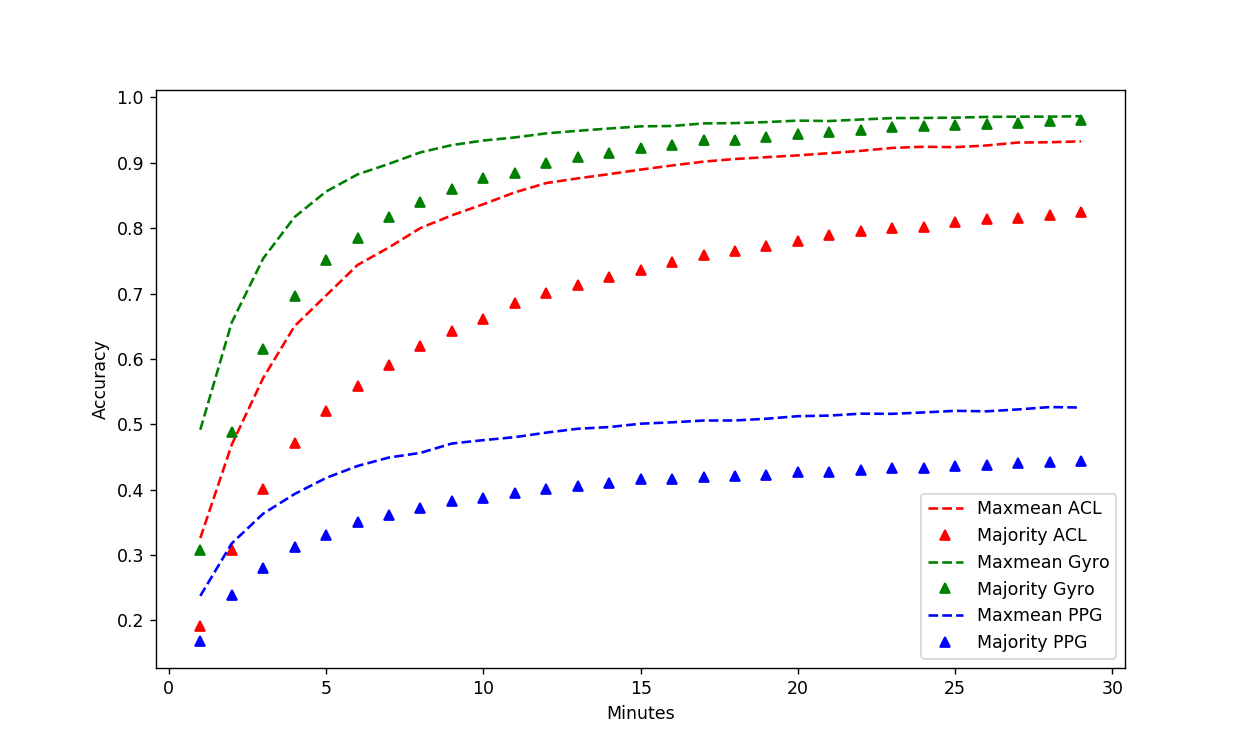

In [87]:
plt.figure(figsize=(10,6))
plt.plot(acl_output[:,0],acl_output[:,1],'r--',label='Maxmean ACL')
plt.plot(acl_output[:,0],acl_output[:,2],'r^',label='Majority ACL')
plt.plot(gyro_output[:,0],gyro_output[:,1],'g--',label='Maxmean Gyro')
plt.plot(gyro_output[:,0],gyro_output[:,2],'g^',label='Majority Gyro')
plt.plot(ppg_output[:,0],ppg_output[:,1],'b--',label='Maxmean PPG')
plt.plot(ppg_output[:,0],ppg_output[:,2],'b^',label='Majority PPG')
plt.legend()
plt.xlabel('Minutes')
plt.ylabel('Accuracy')
plt.show()


In [62]:
np.mean(y_test_pred_window,axis=0).shape

(253,)